# Applied Data Science Capstone Project - The Battle of Neighborhoods <a id="Top"></a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
Table of Content
<ul>
<li>1. <a href="#Part_1">Introduction/Business Problem</a></li>
<li>2. <a href="#Part_2">Data</a></li>
<li>3. <a href="#Part_3">Methodology</a></li>
    <ul>
        <li>3.1 <a href="#Part_3_1">San Francisco Crime Data Analysis</a></li>
        <li>3.2 <a href="#Part_3_2">San Francisco Housing Data Analysis</a></li>
        <li>3.3 <a href="#Part_3_3">Generating Crime and Housing Maps</a></li>
        <li>3.4 <a href="#Part_3_4">Exploring Venues in San Francisco Neighborhood</a></li>
    </ul>
<li>4. <a href="#Part_4">Results</a></li>
    <ul>
        <li>4.1 <a href="#Part_4_1">Crime and Housing Maps</a></li>
        <li>4.2 <a href="#Part_4_2">A Closer Look at the Proposed Location</a></li>
    </ul>    
<li>5. <a href="#Part_5">Discussion</a></li>
<li>6. <a href="#Part_6">Conclusion</a></li>    
</ul>
</font>
</div>

---

## 1. Introduction/Business Problem <a id="Part_1"></a>
<a href="#Top">Back to page top</a>

An investor is looking to open a new restaurant in San Francisco, but he is not sure about the best location for his new venue and needs input for making the decision. San Francisco is rather busy city famous for its business innovation and several famous tourit attractions. So while it looks promising to set up a new restaurant business in San Francisco, the venue's location must be carefully picked in order to maximize the profit. According to <a href="https://www.foodnewsfeed.com/fsr/vendor-bylines/8-factors-choosing-new-restaurant-location">an analysis</a> in the FSR Magazine, the 8 factors for choosing a new restaurant location are

1. Visibility - look for foot and car traffic patterns that can give the venue the best visibility.
2. Parking - need to have sufficient parking space for customers.
3. Space size - consider how big of a space one needs for restaurant requirements.
4. Crime rates - avoid crime-laden areas in the city.
5. Surrounding businesses and competitor analysis - know what types of restaurant would do well in a certain area. Know what will distinguish a new restaurant from competitors.
6. Acessibility - keep in mind about things like off-the-hightway locations, locations near busy intersections.
7. Affordability - the cost of the venue space (rental or purchase) is a bottom-line consideration for any business.
8. Safety - workplace safty is important for the restaurant owner as well as workers.

In the capstone project, we will get the help from FourSquare API to address at least part of these considerations. 

---

## 2. Data <a id="Part_2"></a>
<a href="#Top">Back to page top</a>

Because of the availability of datasets, we will not address all of the factors listed above. However, we will work on some of the most important factors such as visibility, parking, crime rates, and affordability. We will utilize the following datasets/tools.

Static datasets:

1. Police Department Incident Reports: 2018 to Present (<a href="https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783">Link</a>). The dataset includes police incident reports filed by officers and by individuals through self-service online reporting for non-emergency cases. Reports included are those for incidents that occurred starting January 1, 2018 onward and have been approved by a supervising officer. 
2. MTA On Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_onstreet/up9y-3nmx">Link</a>). The dataset contains locations and space count of unmetered motorcycle parking for the City of San Francisco.
3. MTA Off Street Parking Census (<a href="https://data.sfgov.org/Transportation/MTA-parkingcensus_offstreet/dkzc-uy8h">Link</a>). SFMTA managed off street parking locations, hours, and amenities. Includes both lots and garages.
4. San Francisco Historica Secured Property Tax Rolls, 2007-2015 (<a href="https://www.kaggle.com/datasf/sf-historic-secured-property-tax-rolls">Link</a>). This dataset includes the SF Office of the Assessor-Recorder’s secured property tax roll spanning from 2007 to 2015. We will use the latest data as a measure of the cost of venue space.
5. San Francisco Realtor Neighborhoods (<a href="https://data.sfgov.org/Geographic-Locations-and-Boundaries/Realtor-Neighborhoods/5gzd-g9ns/data">Link</a>)

Search engines:
1. <a href="https://foursquare.com/">Foursquare</a>. We will use the foursquare API to carry out venue and point of interest search. The results will give us an idea of the neighborhood of the venue's potential location.
2. <a href="https://www.parkwhiz.com/">PARKWHIZ</a>. We intend to use the static dataset to look up parking space information near the potential venue location. PARKWHIZ is a quick and convenient alternative.

---

## 3. Methodology <a id="Part_3"></a>
<a href="#Top">Back to page top</a>

In this section, we are going to explore San Francisco crime and housing datasets and answer two of the most important factors discussed in the Introduction. Then, using the Foursquare API, we will explore neighborhoods of the city of San Francisco. The neighborhoods will be clustered using the $k$-mean algorithm. The combined results will provide us insights into possible locations for opening a new restaurant.

#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pysal as ps
import requests

from pandas.io.json import json_normalize
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from geopy.geocoders import Nominatim
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point
from sklearn.cluster import KMeans
#from branca.utilities import split_six

%matplotlib inline

/Users/chiachen/miniconda3/envs/mlenv/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


### 3.1 San Francisco Crime Data Analysis <a id="Part_3_1"></a>
<a href="#Top">Back to page top</a>

Read in the San Francisco Police Department Incident Reports and perform an initial check.

In [2]:
df_crime = pd.read_csv("./Police_Department_Incident_Reports__2018_to_Present.csv")
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111531 entries, 0 to 111530
Data columns (total 26 columns):
Incident Datetime          111531 non-null object
Incident Date              111531 non-null object
Incident Time              111531 non-null object
Incident Year              111531 non-null int64
Incident Day of Week       111531 non-null object
Report Datetime            111531 non-null object
Row ID                     111531 non-null int64
Incident ID                111531 non-null int64
Incident Number            111531 non-null int64
CAD Number                 86415 non-null float64
Report Type Code           111531 non-null object
Report Type Description    111531 non-null object
Filed Online               23641 non-null object
Incident Code              111531 non-null int64
Incident Category          111520 non-null object
Incident Subcategory       111520 non-null object
Incident Description       111531 non-null object
Resolution                 111531 non-null ob

First five rows of the dataset.

In [3]:
pd.set_option('display.max_columns', 100)
df_crime.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point
0,2018/01/01 01:30:00 AM,2018/01/01,01:30,2018,Monday,2018/01/01 02:13:00 AM,61870203073,618702,180000263,180010563.0,II,Initial,NaN,3073,Robbery,Robbery - Other,"Robbery, W/ Other Weapon",Open or Active,JUSTIN DR \ COLLEGE AVE,21236000.0,Ingleside,Bernal Heights,9.0,37.732261,-122.423486,"(37.732261252752224, -122.42348641495892)"
1,2018/01/01 01:59:00 AM,2018/01/01,01:59,2018,Monday,2018/01/01 01:59:00 AM,61870768000,618707,180000326,180010504.0,II,Initial,NaN,68000,Fire Report,Fire Report,Fire Report,Open or Active,16TH ST \ MISSION ST,24170000.0,Mission,Mission,9.0,37.765051,-122.419669,"(37.76505133632968, -122.41966897380142)"
2,2018/01/01 02:28:00 AM,2018/01/01,02:28,2018,Monday,2018/01/01 02:31:00 AM,61870904134,618709,180000348,180010636.0,II,Initial,NaN,4134,Assault,Simple Assault,Battery,Open or Active,03RD ST \ PERRY ST,20657000.0,Southern,South of Market,6.0,37.782119,-122.396841,"(37.78211912156566, -122.39684142850209)"
3,2018/01/01 02:28:00 AM,2018/01/01,02:28,2018,Monday,2018/01/01 02:31:00 AM,61870928160,618709,180000348,180010636.0,II,Initial,NaN,28160,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Vehicle",Open or Active,03RD ST \ PERRY ST,20657000.0,Southern,South of Market,6.0,37.782119,-122.396841,"(37.78211912156566, -122.39684142850209)"
4,2018/01/01 02:08:00 AM,2018/01/01,02:08,2018,Monday,2018/01/01 02:08:00 AM,61871004014,618710,180000285,180010537.0,II,Initial,NaN,4014,Assault,Aggravated Assault,"Assault, Aggravated, W/ Force",Cite or Arrest Adult,CESAR CHAVEZ ST \ CAPP ST \ MISSION ST,21304000.0,Mission,Bernal Heights,9.0,37.748166,-122.418221,"(37.74816568813204, -122.41822117169174)"


The most important columns are Incident Category, Latitude, Longitude, and time stamps. We remove columns that are not needed for the analysis.

In [4]:
columns = ['Incident Datetime', 'Incident Day of Week', 'Incident Year', 
           'Report Datetime', 'Row ID', 'Incident ID', 'CAD Number', 'Report Type Code', 
           'Report Type Description', 'Filed Online', 'Incident Code', 'Incident Subcategory', 
           'Incident Description', 'Intersection', 'CNN', 'Analysis Neighborhood', 
           'Supervisor District', 'Resolution', 'point']
df_crime = df_crime.drop(columns, axis=1)

Dropping NaN rows from the remaining dataset.

In [5]:
df_crime.isnull().sum()

Incident Date           0
Incident Time           0
Incident Number         0
Incident Category      11
Police District         0
Latitude             5575
Longitude            5575
dtype: int64

In [6]:
df_crime.dropna(inplace=True)
df_crime.isnull().sum()

Incident Date        0
Incident Time        0
Incident Number      0
Incident Category    0
Police District      0
Latitude             0
Longitude            0
dtype: int64

Get a list the type of incidents reported

In [7]:
df_crime['Incident Category'].unique()

array(['Robbery', 'Fire Report', 'Assault', 'Malicious Mischief',
       'Larceny Theft', 'Non-Criminal', 'Miscellaneous Investigation',
       'Disorderly Conduct', 'Warrant', 'Weapons Carrying Etc',
       'Recovered Vehicle', 'Other Miscellaneous', 'Burglary',
       'Missing Person', 'Suspicious Occ', 'Civil Sidewalks', 'Fraud',
       'Motor Vehicle Theft', 'Traffic Violation Arrest', 'Drug Offense',
       'Weapons Offense', 'Offences Against The Family And Children',
       'Stolen Property', 'Lost Property', 'Other Offenses',
       'Traffic Collision', 'Suicide', 'Homicide', 'Vehicle Misplaced',
       'Other', 'Family Offense', 'Forgery And Counterfeiting',
       'Sex Offense', 'Arson', 'Courtesy Report', 'Case Closure',
       'Gambling', 'Drug Violation', 'Prostitution', 'Juvenile Offenses',
       'Embezzlement', 'Vehicle Impounded', 'Vandalism',
       'Human Trafficking (A), Commercial Sex Acts', 'Liquor Laws',
       'Suspicious', 'Motor Vehicle Theft?', 'Rape', 'Weapo

Remove the 'Non-Criminal' column.

In [8]:
df_crime = df_crime[df_crime['Incident Category'] != 'Non-Criminal'].reset_index(drop=True)

Visualize crime distribution by category.

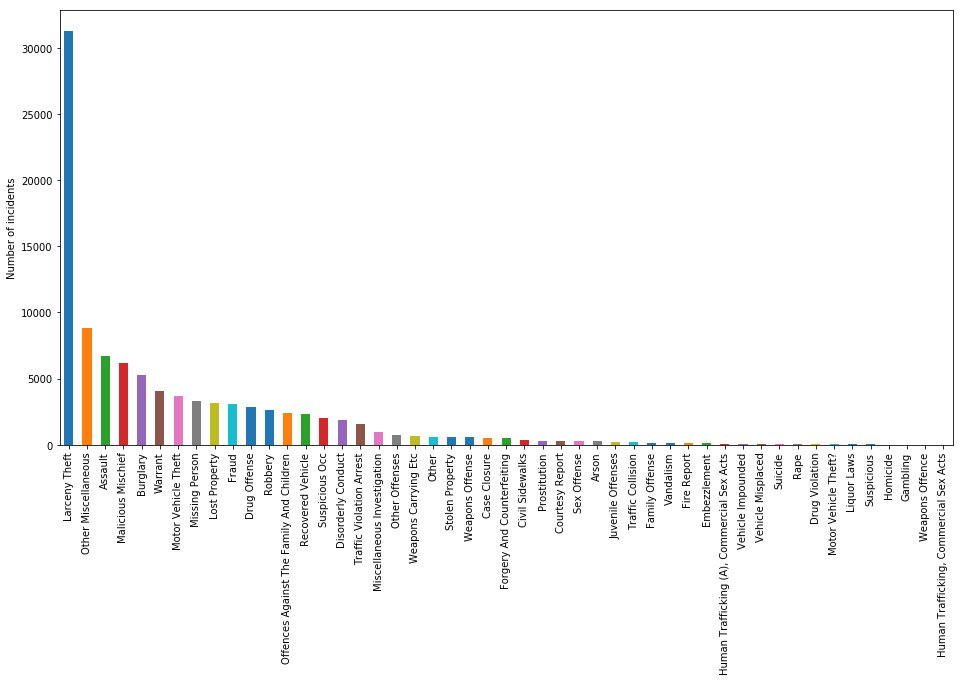

In [9]:
df_crime['Incident Category'].value_counts().plot(kind='bar', figsize=(16,8))
plt.ylabel('Number of incidents')
plt.show()

The number one category is larceny theft, followed by assault and burglary, not including 'Other Miscellaneous' and 'Miscellaneous Mischief.'

Visualize crime distribution by police districts.

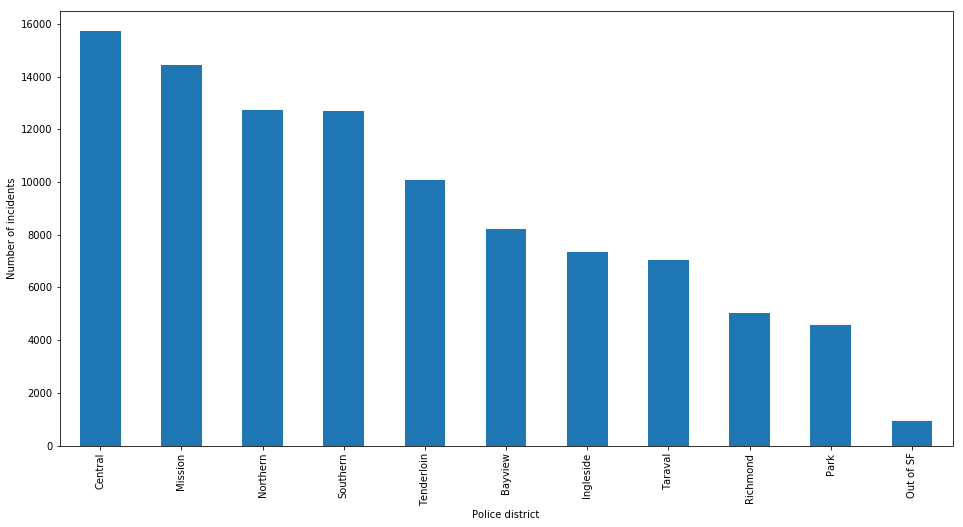

In [10]:
# calculating total number of incidents per district
crimedata_police_district = pd.DataFrame(df_crime['Police District'].value_counts().astype(float))
crimedata_police_district = crimedata_police_district.reset_index()
crimedata_police_district.columns = ['District', 'Number']
crimedata_police_district.plot(kind='bar', figsize=(16,8), legend=None)
xticks = [i for i in range(len(crimedata_police_district))]
plt.xticks(xticks, list(crimedata_police_district['District']))
plt.xlabel('Police district')
plt.ylabel('Number of incidents')
plt.show()

It appears that the Central Police District has the most number of incidents. The next district is Mission district.

#### Process the crime data for mapping
We first convert the Pandas *df_crime* into a GeoPandas GeoDataFrame, a spatial version of *df_crime*. This is done by first creating Shapely point geometry objects with proper coordinate projection for each record. Then we attach the results as a new column to *df_crime*.

Creating Shapely object for each record. Details of the coordinate system, ESPG 4326 which represents the standard WGS84 coordinate system, can be found in <a href="http://geopandas.org/projections.html">this link</a>. Here we implement the Point() function from the shapely package.

In [11]:
geometry = gpd.GeoSeries(df_crime.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1), crs={'init': 'epsg:4326'})

Convert *df_crime* into GeoDataFrame.

In [12]:
df_crime = gpd.GeoDataFrame(df_crime, geometry=geometry)
df_crime.head()

,Incident Date,Incident Time,Incident Number,Incident Category,Police District,Latitude,Longitude,geometry
0,2018/01/01,01:30,180000263,Robbery,Ingleside,37.732261,-122.423486,POINT (-122.4234864149589 37.73226125275223)
1,2018/01/01,01:59,180000326,Fire Report,Mission,37.765051,-122.419669,POINT (-122.4196689738014 37.76505133632968)
2,2018/01/01,02:28,180000348,Assault,Southern,37.782119,-122.396841,POINT (-122.3968414285021 37.78211912156566)
3,2018/01/01,02:28,180000348,Malicious Mischief,Southern,37.782119,-122.396841,POINT (-122.3968414285021 37.78211912156566)
4,2018/01/01,02:08,180000285,Assault,Mission,37.748166,-122.418221,POINT (-122.4182211716917 37.74816568813204)


To map out the crime data, there are three geological units we can work with: police districe, census tracts, and neighborhoods. Here we choose the last one which is designed by San Francisco Association of Realtors. The data can be obtained from <a href="https://data.sfgov.org/Geographic-Locations-and-Boundaries/Realtor-Neighborhoods/5gzd-g9ns/data">DataSF</a>. We download the shape file from the website and import it using GeoPandas.

In [13]:
nbrhoods = gpd.read_file('sf_neighborhoods.shp')
nbrhoods.head()

,nbrhood,nid,sfar_distr,geometry
0,Alamo Square,6e,District 6 - Central North,POLYGON ((-122.4294839489174 37.77509623070431...
1,Anza Vista,6a,District 6 - Central North,POLYGON ((-122.4474643913587 37.77986335309237...
2,Balboa Terrace,4a,District 4 - Twin Peaks West,"POLYGON ((-122.464508862148 37.73220849554402,..."
3,Bayview,10a,District 10 - Southeast,"POLYGON ((-122.38758527039 37.7502633777501, -..."
4,Bernal Heights,9a,District 9 - Central East,POLYGON ((-122.4037549223623 37.74919006373567...


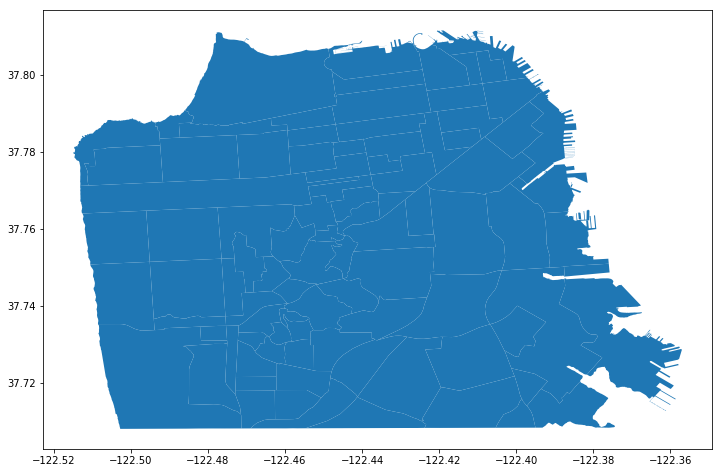

In [71]:
nbrhoods.plot(figsize=(12,14))
plt.show()

Check *nbrhoods*'s coordinate reference system.

In [14]:
print(nbrhoods.crs)

{'init': 'epsg:4326'}


#### Aggregate crime numbers for each neighborhood

Using the geological information in *df_crime*, we can calculate the number of crimes in each neighborhood by implementing GeoPandas' sjoin function. Since we want to aggregate the number in each neighborhood, we set op='within.' The resulted GeoDataFrame is further grouped by neighborhood. 

In [15]:
nbh_crime_counts = gpd.tools.sjoin(df_crime.to_crs(nbrhoods.crs), nbrhoods, how="inner", op='intersects').groupby('nbrhood').size()
nbh_crime_counts = pd.DataFrame(data=nbh_crime_counts.reset_index())
nbh_crime_counts.columns=['nbrhood', 'incident_counts']
nbh_crime_counts.head()

,nbrhood,incident_counts
0,Alamo Square,687
1,Anza Vista,310
2,Balboa Terrace,49
3,Bayview,3185
4,Bayview Heights,253


Finally, we combine the nbh_crime_counts and the nbrhoods GeoDataFrames using the merge function. We use __nbrhood__ as the key where the two frames are joined. Details of the implementation can be found <a href="http://geopandas.org/mergingdata.html">here</a>.

In [16]:
nbrhoods = nbrhoods.merge(nbh_crime_counts, on='nbrhood')
nbrhoods.head()

,nbrhood,nid,sfar_distr,geometry,incident_counts
0,Alamo Square,6e,District 6 - Central North,POLYGON ((-122.4294839489174 37.77509623070431...,687
1,Anza Vista,6a,District 6 - Central North,POLYGON ((-122.4474643913587 37.77986335309237...,310
2,Balboa Terrace,4a,District 4 - Twin Peaks West,"POLYGON ((-122.464508862148 37.73220849554402,...",49
3,Bayview,10a,District 10 - Southeast,"POLYGON ((-122.38758527039 37.7502633777501, -...",3185
4,Bernal Heights,9a,District 9 - Central East,POLYGON ((-122.4037549223623 37.74919006373567...,1561


Delete *df_crime* in order to reduce memory usage.

In [17]:
del df_crime

---

### 3.2 San Francisco Housing Data Analysis <a id="Part_3_2"></a>
<a href="#Top">Back to page top</a>

Import the San Francisco Historica Secured Property Tax Rolls, 2007-2015 and perform an initial check.

In [18]:
df_import = pd.read_csv('Historic_Secured_Property_Tax_Rolls.csv')
df_import.info()

/Users/chiachen/miniconda3/envs/mlenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612110 entries, 0 to 1612109
Data columns (total 43 columns):
Closed Roll Fiscal Year                       1612109 non-null float64
Property Location                             1612110 non-null object
Neighborhood Code                             1611431 non-null object
Neighborhood Code Definition                  1564368 non-null object
Block and Lot Number                          1612110 non-null object
Volume Number                                 1612110 non-null int64
Property Class Code                           1611252 non-null object
Property Class Code Definition                1596776 non-null object
Year Property Built                           1483511 non-null float64
Number of Bathrooms                           1612110 non-null float64
Number of Bedrooms                            1612110 non-null int64
Number of Rooms                               1612110 non-null int64
Number of Stories                             1

We will work with the following columns only.

In [19]:
columns = ['Block and Lot Number', 
           'Closed Roll Assessed Fixtures Value',
           'Closed Roll Assessed Improvement Value',
           'Closed Roll Assessed Land Value',
           'Closed Roll Assessed Personal Prop Value', 'Neighborhoods - Analysis Boundaries',
           'Location']

Get the data obtained in 2014. The *df_housing* will only contain columns defined in the last cell.

In [20]:
df_housing = df_import[df_import['Closed Roll Fiscal Year']==2014.0].loc[:,columns].reset_index(drop=True)

Check if there's any NaNs. If so, drop those rows.

In [21]:
df_housing.isnull().sum()

Block and Lot Number                           0
Closed Roll Assessed Fixtures Value            0
Closed Roll Assessed Improvement Value         0
Closed Roll Assessed Land Value                0
Closed Roll Assessed Personal Prop Value       0
Neighborhoods - Analysis Boundaries         2497
Location                                    1619
dtype: int64

In [22]:
df_housing.dropna(inplace=True)
df_housing.isnull().sum()

Block and Lot Number                        0
Closed Roll Assessed Fixtures Value         0
Closed Roll Assessed Improvement Value      0
Closed Roll Assessed Land Value             0
Closed Roll Assessed Personal Prop Value    0
Neighborhoods - Analysis Boundaries         0
Location                                    0
dtype: int64

Compute tha total value of the house. The total value is the combination of assessed fixtures value, improvement value, land value, and personal prop value.

In [23]:
df_housing['total_price'] = df_housing['Closed Roll Assessed Fixtures Value'] + \
                            df_housing['Closed Roll Assessed Improvement Value'] + \
                            df_housing['Closed Roll Assessed Land Value'] + \
                            df_housing['Closed Roll Assessed Personal Prop Value']

In [24]:
df_housing.head()

,Block and Lot Number,Closed Roll Assessed Fixtures Value,Closed Roll Assessed Improvement Value,Closed Roll Assessed Land Value,Closed Roll Assessed Personal Prop Value,Neighborhoods - Analysis Boundaries,Location,total_price
0,3751435,0.0,149168.0,149168.0,0.0,South of Market,"(37.7816504619473, -122.399116945614)",298336.0
2,6276009,0.0,270000.0,405000.0,0.0,Excelsior,"(37.7190514589638, -122.433999199176)",675000.0
3,3751420,0.0,128078.0,128078.0,0.0,South of Market,"(37.7816504619473, -122.399116945614)",256156.0
4,7517378,0.0,129545.0,141594.0,0.0,Noe Valley,"(37.7463212609468, -122.441519528492)",271139.0
5,3735098,0.0,336716.0,336716.0,0.0,Financial District/South Beach,"(37.7857477114134, -122.397398669759)",673432.0


Change the format of GPS coordinates so that it is consistent with other datasets.

In [25]:
coordinates = df_housing['Location'].str.strip('()')                                \
                                    .str.split(', ', expand=True)                   \
                                    .rename(columns={0:'Latitude', 1:'Longitude'}) 

In [26]:
columns = list(df_housing.columns) + list(coordinates.columns)

In [27]:
df_housing = pd.concat([df_housing, coordinates], axis=1, ignore_index=True)
df_housing.columns = columns
df_housing = df_housing.drop(columns=['Closed Roll Assessed Fixtures Value',
                                      'Closed Roll Assessed Improvement Value',
                                      'Closed Roll Assessed Land Value',
                                      'Closed Roll Assessed Personal Prop Value',
                                      'Location'])

Latitude and longitude are text objects. Convert them to float.

In [28]:
df_housing[['Latitude','Longitude']] = df_housing[['Latitude','Longitude']].apply(pd.to_numeric)

Final checkup.

In [29]:
df_housing.head()

,Block and Lot Number,Neighborhoods - Analysis Boundaries,total_price,Latitude,Longitude
0,3751435,South of Market,298336.0,37.781650,-122.399117
2,6276009,Excelsior,675000.0,37.719051,-122.433999
3,3751420,South of Market,256156.0,37.781650,-122.399117
4,7517378,Noe Valley,271139.0,37.746321,-122.441520
5,3735098,Financial District/South Beach,673432.0,37.785748,-122.397399


In [30]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204319 entries, 0 to 206815
Data columns (total 5 columns):
Block and Lot Number                   204319 non-null object
Neighborhoods - Analysis Boundaries    204319 non-null object
total_price                            204319 non-null float64
Latitude                               204319 non-null float64
Longitude                              204319 non-null float64
dtypes: float64(3), object(2)
memory usage: 9.4+ MB


#### Processing the housing data for mapping
Following the steps in the previous section, we are going to convert *df_housing* into GeoDataFrame which is will be used for mapping. First, we generate the Shapely point column by combining Longitude and Latitude data.

In [31]:
geometry_housing = gpd.GeoSeries(df_housing.apply(lambda z: Point(z['Longitude'], z['Latitude']), 1), crs={'init': 'epsg:4326'})

In [32]:
df_housing = gpd.GeoDataFrame(df_housing, geometry=geometry_housing)
df_housing.head()

,Block and Lot Number,Neighborhoods - Analysis Boundaries,total_price,Latitude,Longitude,geometry
0,3751435,South of Market,298336.0,37.781650,-122.399117,POINT (-122.399116945614 37.7816504619473)
2,6276009,Excelsior,675000.0,37.719051,-122.433999,POINT (-122.433999199176 37.7190514589638)
3,3751420,South of Market,256156.0,37.781650,-122.399117,POINT (-122.399116945614 37.7816504619473)
4,7517378,Noe Valley,271139.0,37.746321,-122.441520,POINT (-122.441519528492 37.7463212609468)
5,3735098,Financial District/South Beach,673432.0,37.785748,-122.397399,POINT (-122.397398669759 37.7857477114134)


#### Compute average housing price per neighborhood
Using sjoin and mean functions, we compute average housing price in each neighborhood. The price is in units of million.

In [33]:
nbh_house_avg_value = gpd.tools.sjoin(df_housing.to_crs(nbrhoods.crs), nbrhoods, how="inner", op='intersects').groupby('nbrhood').mean()
nbh_house_avg_value = pd.DataFrame(data=nbh_house_avg_value.reset_index())
nbh_house_avg_value = nbh_house_avg_value.drop(columns=['Latitude', 'Longitude', 'index_right', 'incident_counts'])
nbh_house_avg_value.columns=['nbrhood', 'house_avg_price']

# Normalize the price by one million.
nbh_house_avg_value['house_avg_price'] = nbh_house_avg_value['house_avg_price'] / 1_000_000
nbh_house_avg_value.head()

,nbrhood,house_avg_price
0,Alamo Square,0.862016
1,Anza Vista,1.121534
2,Balboa Terrace,0.737963
3,Bayview,0.439684
4,Bayview Heights,0.296895


Finally, we merge the average housing price information with the *nbrhoods* GeoDataFrame.

In [34]:
nbrhoods = nbrhoods.merge(nbh_house_avg_value, on='nbrhood')
nbrhoods.head()

,nbrhood,nid,sfar_distr,geometry,incident_counts,house_avg_price
0,Alamo Square,6e,District 6 - Central North,POLYGON ((-122.4294839489174 37.77509623070431...,687,0.862016
1,Anza Vista,6a,District 6 - Central North,POLYGON ((-122.4474643913587 37.77986335309237...,310,1.121534
2,Balboa Terrace,4a,District 4 - Twin Peaks West,"POLYGON ((-122.464508862148 37.73220849554402,...",49,0.737963
3,Bayview,10a,District 10 - Southeast,"POLYGON ((-122.38758527039 37.7502633777501, -...",3185,0.439684
4,Bernal Heights,9a,District 9 - Central East,POLYGON ((-122.4037549223623 37.74919006373567...,1561,0.448200


Delete *df_import* and *df_housing* datasets in order to save memory.

In [35]:
del df_import
del df_housing

---

### 3.3 Generating Crime and Housing Maps <a id="Part_3_3"></a>
<a href="#Top">Back to page top</a>

In this section, we are going to use folium to produce crime and housing price maps of San Francisco using the data prepared in the previous two sections. Before that we first use GeoPandas' representative_point() function to generate a representative location for each neighborhood. This data will be used to create popups on the map.

In [36]:
#nbh_centroid = pd.DataFrame(nbrhoods.centroid)
nbh_centroid = pd.DataFrame(nbrhoods.representative_point())
nbh_centroid.columns=(['centroid'])
nbh_centroid['nbrhood'] = nbrhoods['nbrhood']
nbh_centroid['incident_counts'] = nbrhoods['incident_counts']
nbh_centroid['house_avg_price'] = nbrhoods['house_avg_price']

lat = []
lng = []
for index, row in nbh_centroid.iterrows():
    tmp = str(row[0]).strip('POINT ()').split(' ')
    lng.append(float(tmp[0]))
    lat.append(float(tmp[1]))
    #print(tmp[0], tmp[1])
    
nbh_centroid['Latitude'] = lat
nbh_centroid['Longitude'] = lng

nbh_centroid = nbh_centroid.drop(columns=['centroid'])

nbh_centroid.head()

,nbrhood,incident_counts,house_avg_price,Latitude,Longitude
0,Alamo Square,687,0.862016,37.776076,-122.433919
1,Anza Vista,310,1.121534,37.780611,-122.443255
2,Balboa Terrace,49,0.737963,37.730649,-122.468267
3,Bayview,3185,0.439684,37.732391,-122.387170
4,Bernal Heights,1561,0.448200,37.740230,-122.415885


Define a function that generates popups.

In [37]:
def get_popups(df, field, name, map_object):
    for lat, lng, nbrhood, value in zip( df['Latitude'], 
                                         df['Longitude'], 
                                         df['nbrhood'], 
                                         df[field]
                                       ):
        label = ("{0}, {1}: {2:.2f}").format(nbrhood, name, value)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=2,
            popup=label,
            color='green',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3).add_to(map_object)

Define San Francisco's GPS coordinates.

In [38]:
SF_Coord = (37.7792808, -122.4192363)

Create the crime map object.

In [39]:
# Create San Francisco base map
SF_crime_map = folium.Map(location=SF_Coord, zoom_start=12)

#geodata = gpd.read_file('./tmp/geo_export_0e291dd6-c6fb-40dd-8323-68a750ad5743.geojson')
# Crime data at the census tract level
threshold_scale = [0, 1000, 2000, 4000, 6000, 8000]
SF_crime_map.choropleth(geo_data        = nbrhoods.to_json(),
                        data            = nbrhoods,
                        columns         = ['nbrhood', 'incident_counts'], 
                        key_on          = 'feature.properties.nbrhood',
                        fill_color      = 'YlOrRd', 
                        fill_opacity    = 0.60, 
                        line_opacity    = 0.60,
                        legend_name     = 'Number of incidents',
                        name            = 'Number of Incidents',
                        threshold_scale = threshold_scale,
                                  reset = True                             
                       )

get_popups(nbh_centroid, 'incident_counts', 'Incident Counts', SF_crime_map)

# Add control layer to the map
#folium.LayerControl().add_to(SF_crime_map)
#SF_crime_map

Create the housing price map object.

In [40]:
# Create San Francisco base map
SF_housing_map = folium.Map(location=SF_Coord, zoom_start=12)

threshold_scale2 = [0.0, 0.5, 1.0, 2.0, 4.0, 8.0]
SF_housing_map.choropleth(geo_data        = nbrhoods.to_json(),
                          data            = nbrhoods,
                          columns         = ['nbrhood', 'house_avg_price'], 
                          key_on          = 'feature.properties.nbrhood',
                          fill_color      = 'YlOrRd', 
                          fill_opacity    = 0.60, 
                          line_opacity    = 0.60,
                          legend_name     = 'Average Housing Price (Million)',
                          name            = 'Average Housing Price',
                          threshold_scale = threshold_scale2,
                          reset           = True
                         )

get_popups(nbh_centroid, 'house_avg_price', 'Avg. House Price (Million)', SF_housing_map)

# Add control layer to the map
#folium.LayerControl().add_to(SF_housing_map)
#SF_housing_map

---

### 3.4 Exploring Venues in San Francisco Neighborhoods <a id="Part_3_4"></a>
<a href="#Top">Back to page top</a>

In this section, are going to use the Foursquare APIs to explore San Francisco neighborhoods and cluster them using k-means clustering. From the Toronto zipcode neighborhood exercise, we learn that k-means will generate at least one cluster that emphasizes on the restaurant section. This is exactly the kind of information needed when we are looking for possible locations for opening a new restaurant.

Set up Foursqure API id and basic API call parameters

In [41]:
# @hidden_cell
CLIENT_ID = 'JBAVIGVGG3N3AWC1FGO2G3U1N3GUOWBEKXFI1SDAOCYYPULD'     
CLIENT_SECRET = 'GPGOGGAB5YFPREDIUHAT5OZNYRDBVGZH1WC21KBQMVEP3BIC' 
VERSION = '20180927'

# Set up the FourSquare API call parameters
RADIUS = 500
LIMIT  = 100

Define the function that extracts the category of the venue.

In [42]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get venue recommendations from Foursquare Expore API
We use the function defined in the Toronto exercise. Here the function calls the __explore__ method to return a list of recommended venues for each neighborhood.

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_check_list = []
    venues_list=[]
    idx = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        num_of_venues_found = len(results)
        if (num_of_venues_found == 0):
            venues_check_list.append(False)
        else:
            venues_check_list.append(True)
        print('{0:4d} Neighborhood: {1:35s}, number of venues found:{2:6d}'.format(idx, name, num_of_venues_found))
        idx = idx + 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['nbrhood', 
                  'nbrhood Latitude', 
                  'nbrhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_check_list)

Apply the function getNearbyVenues() to the neighborhoods whose coordinates are extracted from *nbh_centroid*.

In [44]:
nbhs = nbh_centroid.loc[:, 'nbrhood']
latitudes = nbh_centroid.loc[:, 'Latitude']
longitudes = nbh_centroid.loc[:, 'Longitude']

print('\n            Search radius: {0:8.1f} meters'.format(RADIUS))
print(' Maximum number of venues: {0:6d}\n'.format(LIMIT))
SF_venues, SF_venues_check_list = getNearbyVenues(nbhs, latitudes, longitudes, RADIUS, LIMIT)


            Search radius:    500.0 meters
 Maximum number of venues:    100

   0 Neighborhood: Alamo Square                       , number of venues found:    77
   1 Neighborhood: Anza Vista                         , number of venues found:    16
   2 Neighborhood: Balboa Terrace                     , number of venues found:    16
   3 Neighborhood: Bayview                            , number of venues found:    15
   4 Neighborhood: Bernal Heights                     , number of venues found:    39
   5 Neighborhood: Buena Vista Park/Ashbury Heights   , number of venues found:    57
   6 Neighborhood: Central Richmond                   , number of venues found:   100
   7 Neighborhood: Central Sunset                     , number of venues found:    16
   8 Neighborhood: Clarendon Heights                  , number of venues found:    13
   9 Neighborhood: Corona Heights                     , number of venues found:    62
  10 Neighborhood: Cow Hollow                         , numbe

In [45]:
print(SF_venues.shape)
SF_venues.head()

(3622, 7)


,nbrhood,nbrhood Latitude,nbrhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alamo Square,37.776076,-122.433919,Alamo Square,37.775906,-122.434047,Park
1,Alamo Square,37.776076,-122.433919,Painted Ladies,37.776010,-122.433179,Historic Site
2,Alamo Square,37.776076,-122.433919,Alamo Square Dog Park,37.775878,-122.435740,Dog Run
3,Alamo Square,37.776076,-122.433919,Alamo Square Market & Deli,37.774865,-122.436114,Sandwich Place
4,Alamo Square,37.776076,-122.433919,Church of 8 Wheels,37.774733,-122.430862,Roller Rink


Find out the number of unique categories can be curated from all the returned venues.

In [46]:
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 343 uniques categories.


#### Cluster the neighborhoods using the k-means algorithm: Preprocessing
First we one-hot encode venue categories.

In [47]:
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")

# add postcode column back to dataframe
SF_onehot['nbrhood'] = SF_venues['nbrhood'] 

# move postcode column to the first column
fixed_columns = [SF_onehot.columns[-1]] + list(SF_onehot.columns[:-1])
SF_onehot = SF_onehot[fixed_columns]

SF_onehot.shape

(3622, 344)

Group rows by neighborhood name and by taking the mean of the frequency of occurrence of each category.

In [48]:
SF_grouped = SF_onehot.groupby('nbrhood').mean().reset_index()
SF_grouped.head()

,nbrhood,ATM,Acai House,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,...,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Trattoria/Osteria,Tree,Tunnel,Turkish Restaurant,Tuscan Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Wagashi Place,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Alamo Square,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.012987,0.012987,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.025974,0.0,0.0,0.012987,0.0,0.051948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025974,0.0,0.0,0.0,0.000000,0.012987,0.012987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.025974,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,0.000000,0.0,0.000000,0.0,0.0,0.0,0.012987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012987,0.0000,0.0,0.0,0.0,0.0,0.025974,0.0,0.0,0.0,0.0,0.0
1,Anza Vista,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Balboa Terrace,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0625,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview,0.0,0.0,0.0,0.0,0.0,0.066667,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.066667,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Bayview Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

Define a function that sorts the venues in descending order.

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a dataframe that contains venues in descending order for each zipcode area.

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['nbrhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
SF_venues_sorted = pd.DataFrame(columns=columns)
SF_venues_sorted['nbrhood'] = SF_grouped['nbrhood']

for ind in np.arange(SF_grouped.shape[0]):
    SF_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

print(SF_venues_sorted.shape)
SF_venues_sorted

(92, 11)


,nbrhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,Bar,Record Shop,Sushi Restaurant,Diner,Ethiopian Restaurant,BBQ Joint,Italian Restaurant,Gift Shop,Seafood Restaurant,Cocktail Bar
1,Anza Vista,Café,Health & Beauty Service,Big Box Store,Cosmetics Shop,Burger Joint,Mexican Restaurant,Grocery Store,Bus Station,Tunnel,Southern / Soul Food Restaurant
2,Balboa Terrace,Light Rail Station,Italian Restaurant,Vietnamese Restaurant,Gym,Pharmacy,Bakery,Circus,Park,Playground,Comic Shop
3,Bayview,Southern / Soul Food Restaurant,Light Rail Station,Park,Gym,Grocery Store,Food,African Restaurant,Thrift / Vintage Store,Plaza,Taco Place
4,Bayview Heights,Light Rail Station,Breakfast Spot,Park,Liquor Store,Burger Joint,Yoga Studio,Flea Market,Event Space,Exhibit,Farmers Market
5,Bernal Heights,Park,Coffee Shop,Italian Restaurant,Gourmet Shop,Bakery,Playground,Pet Store,Bus Stop,Butcher,Café
6,Buena Vista Park/Ashbury Heights,Boutique,Bus Station,Park,Trail,Coffee Shop,Clothing Store,Convenience Store,Scenic Lookout,Dog Run,Breakfast Spot
7,Candlestick Point,Football Stadium,Campground,Stadium,Food & Drink Shop,American Restaurant,Soccer Field,Playground,Filipino Restaurant,Electronics Store,Ethiopian Restaurant
8,Central Richmond,Grocery Store,Chinese Restaurant,Sushi Restaurant,Korean Restaurant,Café,Liquor Store,Dim Sum Restaurant,Thai Restaurant,Coffee Shop,Bakery
9,Central Sunset,Chinese Restaurant,Gym / Fitness Center,Liquor Store,Gymnastics Gym,Light Rail Station,Spa,Dessert Shop,Playground,Train Station,Food


#### Cluster the neighborhoods using the k-means algorithm: Realization
We use k-means to cluster the results into 5 clusters.

In [51]:
# Set the number of clusters
kclusters = 5

SF_grouped_clustering = SF_grouped.drop('nbrhood', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=34).fit(SF_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [52]:
# Create the dataframe
SF_merged = SF_venues_sorted

# Add clustering labels
SF_merged['Cluster Labels'] = kmeans.labels_

# Merge SF_grouped with SF_data to add latitude/longitude for each neighborhood
SF_merged = nbh_centroid.join(SF_venues_sorted.set_index('nbrhood'), on='nbrhood')

SF_merged.head()

,nbrhood,incident_counts,house_avg_price,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Alamo Square,687,0.862016,37.776076,-122.433919,Bar,Record Shop,Sushi Restaurant,Diner,Ethiopian Restaurant,BBQ Joint,Italian Restaurant,Gift Shop,Seafood Restaurant,Cocktail Bar,0
1,Anza Vista,310,1.121534,37.780611,-122.443255,Café,Health & Beauty Service,Big Box Store,Cosmetics Shop,Burger Joint,Mexican Restaurant,Grocery Store,Bus Station,Tunnel,Southern / Soul Food Restaurant,0
2,Balboa Terrace,49,0.737963,37.730649,-122.468267,Light Rail Station,Italian Restaurant,Vietnamese Restaurant,Gym,Pharmacy,Bakery,Circus,Park,Playground,Comic Shop,0
3,Bayview,3185,0.439684,37.732391,-122.387170,Southern / Soul Food Restaurant,Light Rail Station,Park,Gym,Grocery Store,Food,African Restaurant,Thrift / Vintage Store,Plaza,Taco Place,0
4,Bernal Heights,1561,0.448200,37.740230,-122.415885,Park,Coffee Shop,Italian Restaurant,Gourmet Shop,Bakery,Playground,Pet Store,Bus Stop,Butcher,Café,0


Generate the San Francisco neighborhood clusters map.

In [53]:
# Create San Francisco base map
SF_cluster_map = folium.Map(location=SF_Coord, zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3.2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, nbrhood, cluster in zip(
                                  SF_merged['Latitude'], 
                                  SF_merged['Longitude'], 
                                  SF_merged['nbrhood'], 
                                  SF_merged['Cluster Labels']):
    label = ("Cluster : {}, Neighborhood: {}").format(cluster, nbrhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(SF_cluster_map)
    
#SF_cluster_map

---

## 4. Results <a id="Part_4"></a>

### 4.1 Crime and Housing Maps <a id="Part_4_1"></a>
<a href="#Top">Back to page top</a>

#### Distribution of San Francisco crimes: 2018 Jan. - 2018 Sep.

In [54]:
display(SF_crime_map)

#### Distribution of 2014 San Francisco average housing price.

In [55]:
display(SF_housing_map)

#### San Francisco neighborhood clusters based on the k-means algorithm

In [56]:
display(SF_cluster_map)

---
#### The proposed location for the new restaurant
The crime and housing price maps suggest that __North Beach__ has a relatively low crime rate and an somewhat below average housing price. This neighborhood is close to attractions such as the Fisherman's Wharf, the Lombard Street and the Colt Tower. This neighborhood belongs to the first cluster. Let's take a look at this cluster.

In [57]:
def examine_clusters(id):
    return SF_merged.loc[SF_merged['Cluster Labels'] == id, SF_merged.columns[[0] + [1] + list(range(5, SF_merged.shape[1]))]]

In [58]:
pd.set_option('display.max_rows', 100)
examine_clusters(0)

,nbrhood,incident_counts,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Alamo Square,687,Bar,Record Shop,Sushi Restaurant,Diner,Ethiopian Restaurant,BBQ Joint,Italian Restaurant,Gift Shop,Seafood Restaurant,Cocktail Bar,0
1,Anza Vista,310,Café,Health & Beauty Service,Big Box Store,Cosmetics Shop,Burger Joint,Mexican Restaurant,Grocery Store,Bus Station,Tunnel,Southern / Soul Food Restaurant,0
2,Balboa Terrace,49,Light Rail Station,Italian Restaurant,Vietnamese Restaurant,Gym,Pharmacy,Bakery,Circus,Park,Playground,Comic Shop,0
3,Bayview,3185,Southern / Soul Food Restaurant,Light Rail Station,Park,Gym,Grocery Store,Food,African Restaurant,Thrift / Vintage Store,Plaza,Taco Place,0
4,Bernal Heights,1561,Park,Coffee Shop,Italian Restaurant,Gourmet Shop,Bakery,Playground,Pet Store,Bus Stop,Butcher,Café,0
5,Buena Vista Park/Ashbury Heights,270,Boutique,Bus Station,Park,Trail,Coffee Shop,Clothing Store,Convenience Store,Scenic Lookout,Dog Run,Breakfast Spot,0
6,Central Richmond,976,Grocery Store,Chinese Restaurant,Sushi Restaurant,Korean Restaurant,Café,Liquor Store,Dim Sum Restaurant,Thai Restaurant,Coffee Shop,Bakery,0
7,Central Sunset,701,Chinese Restaurant,Gym / Fitness Center,Liquor Store,Gymnastics Gym,Light Rail Station,Spa,Dessert Shop,Playground,Train Station,Food,0
9,Corona Heights,175,Gay Bar,Park,Cosmetics Shop,Coffee Shop,Thai Restaurant,Dog Run,Supermarket,Grocery Store,Dim Sum Restaurant,Clothing Store,0
10,Cow Hollow,994,Cosmetics Shop,Wine Bar,French Restaurant,Sandwich Place,Italian Restaurant,Gym / Fitness Center,Salad Place,Gym,Sushi Restaurant,Juice Bar,0


So indeed, the first few most common venues in neighborhoods that belong to cluster #0 are all restaurants which include bars, coffee shops/cafe, Chinese/Japanese/Korean/American/Italian restaurants. 

---

### 4.2 A Closer Look at the Proposed Location <a id="Part_4_2"></a>
<a href="#Top">Back to page top</a>

According to the maps, it appears that the neighborhood __Russian Hills__ has a relatively low crime rate and housing price. This neighborhood is close several attractions too. Let's use Foursquare API to explore vicinities of this neighborhood.

In [59]:
nbh_name = 'North Beach'
nbh_index = nbrhoods.index[nbrhoods['nbrhood'] == nbh_name][0]
nbh_lat, nbh_lng = nbh_centroid.loc[nbh_index, ['Latitude', 'Longitude']]

nbrhoods.loc[nbh_index]

nbrhood                                                  North Beach
nid                                                               8d
sfar_distr                                    District 8 - Northeast
geometry           POLYGON ((-122.4172945622149 37.80506527491107...
incident_counts                                                  732
house_avg_price                                             0.799696
Name: 53, dtype: object

In [60]:
SF_venues_sorted.loc[SF_venues_sorted['nbrhood'] == nbh_name]

,nbrhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
58,North Beach,Italian Restaurant,Pizza Place,Bakery,Chinese Restaurant,Coffee Shop,Cocktail Bar,Dive Bar,Sandwich Place,Café,Mexican Restaurant,0


This table shows that the North Beach already has many restaurants in the area. This sort of indicates that indeed North Beach is an ideal neighborhood for opening a new restanrant. But we have many coompetitors! To know our potential competitors, we use Foursquare API and this time add __food__ to the parameter *section* to look for restaurants in this neighborhood. Using the results, we'll map out our competitors.

In [61]:
# Set up the FourSquare API call
section = 'food'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={0}&client_secret={1}&v={2}&ll={3},{4}&section={5}&radius={6}&limit={7}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    nbh_lat,
    nbh_lng,
    section,
    RADIUS,
    LIMIT)

# Fetch the top 100 venues
results = requests.get(url).json()

In [62]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tony’s Pizza Napoletana,Pizza Place,37.800328,-122.409040
1,The Italian Homemade Company,Italian Restaurant,37.801497,-122.411795
2,Park Tavern,New American Restaurant,37.801097,-122.409301
3,Trattoria Contadina,Trattoria/Osteria,37.800078,-122.412422
4,Mario's Bohemian Cigar Store Cafe,Café,37.800391,-122.409876


In [63]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

63 venues were returned by Foursquare.


In [64]:
# Create San Francisco base map
target_map = folium.Map(location=(nbh_lat, nbh_lng), zoom_start=17)

for lat, lng, categories in zip(
                                  nearby_venues['lat'], 
                                  nearby_venues['lng'], 
                                  nearby_venues['categories']):
    label = ("{}").format(categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(target_map)
    
target_map

The above map shows that the restaurants are located mostly in the blocks along Columbus Avene. We can get a list of restaurant categories from *nearby_venues*.

In [65]:
venue_category_list = list(nearby_venues['categories'].unique())
venue_category_list

['Pizza Place',
 'Italian Restaurant',
 'New American Restaurant',
 'Trattoria/Osteria',
 'Café',
 'Seafood Restaurant',
 'Argentinian Restaurant',
 'Breakfast Spot',
 'Bakery',
 'Tuscan Restaurant',
 'Sushi Restaurant',
 'Deli / Bodega',
 'Mexican Restaurant',
 'South American Restaurant',
 'Taco Place',
 'Chinese Restaurant',
 'Sicilian Restaurant',
 'Asian Restaurant',
 'Sandwich Place',
 'Diner',
 'Burger Joint',
 'Gastropub',
 'Persian Restaurant',
 'French Restaurant',
 'Thai Restaurant',
 'Indian Restaurant',
 'Southern / Soul Food Restaurant']

---

## 5. Discussion <a id="Part_5"></a>
<a href="#Top">Back to page top</a>

By analyzing public datasets obtained from <a href="https://datasf.org/opendata/">DataSF</a>, we locate __North Beach__ as a possible neighborhood that is ideal for opening a new restaurant. We rely on aggregating crime and housing price data, the two primary factors that are critical for determining the location. With the help from the Foursquare API, we further demonstrate that __North Beach__ indeed is a good candidate by showing there are already restaurants in this area along the Columbus Avenue. We also obtain a list of our competitors by using again the Foursquare Explore API, and are able to pinpoint the competitors' location. 
At the end, while we have identified an ideal neighborhood, we are also facing rather strong competitions. To  differenciate our new restaurant from competitors, we need inputs from the data. Obviously, our analysis has rooms for improvement.

1. Visibility: Our results indicate that __North Beach__ should have sizable foot and car traffic along the Columbus Avenue. So to follow these traffics, we can certainly open our new restaurant somewhere on the avenue. A good alternative is the blocks away from the avenue. However, we need to analyze the data in further detail so that the traffic pattern can be revealed.

2. Competitor analysis: In Section 4.2, we very list the categories of restaurant in __North Beach__ neighborhood. This list provides an excellent overview of our competitors. It also guides us in determining which category we should be focusing on or avoiding. An obvious improvement here is to cluster the restaurant categories. The results could let us know the landscape of the restaurant business in this neighborhood.

3. Parking: This is a rather important factor that is not addressed in our analysis. While we have public parking space data, there are many private parkings in San Francisco and we don't have the data. The next step is to obtain a distribution of these parking spaces. Or one could extract the parking information in realtime by using the ParkWhiz API calls.

---

## 6. Conclusion <a id="Part_6"></a>
<a href="#Top">Back to page top</a>

In this capstone project, we address the business problem of finding a good location in San Francisco for opening a new restaurant. We identify the most important factors that could impact the choice. Using crime and housing price datasets, we are able to locate a possible neighborhood that has a relatively low crime rate and housing cost. Foursquare API recommendation results also seem to support our pick. But we equally are facing competitions. We have discussed several possible improvements. It would be a very interesting followup project if somehow we could automate the location recommendation process. In thsi project, we sort of idtentify the neighborhood by just eyeballing the maps and results. To build an automatic recommender, we would have to design a quantitative measure that allows us to gauge each location. The final location is obviously a compromise between all the factors that could impact the selection. So in addition to the clustering algorithm, we may need other machine learning models such as regression to determine or estimate the score. We'll leave this for future projects.